# Flexible Job Shop Scheduling Problem with Transportation (FJSPT)

**Цель:** Минимизировать общую продолжительность выполнения всех работ (makespan) — .

### 1. Основные компоненты

* **Работы ($J$):** Множество из  работ. Каждая работа состоит из последовательности (маршрута) операций .
* **Оборудование ($M$):** Множество из  станков.
* **Транспорт ($V$):** Множество из  транспортных средств (ТС).

### 2. Условия выполнения операций

* **Производственные операции ($u$):** Каждая операция может быть выполнена на любом станке из заданного подмножества $M_u \subseteq M$. Время обработки $p^a_u$ зависит от выбранного станка.
* **Транспортные операции ($t_u$):** Каждой производственной операции $u$ предшествует транспортировка $t_u$ (включая первую операцию — из депо LU к станку). Транспортировка после последней операции не учитывается.
* **Особенности ТС:** Любое ТС может выполнить любую транспортную операцию ($V^{t_u} = V$). Время перевозки $p^J_{t_u}$ зависит только от расстояния и не зависит от выбора ТС.

### 3. Логистика и временные затраты

* **Перемещения:** Учитывается время перемещения как с грузом, так и без него (порожний пробег). Время в пути между станками $m_a$ и $m_b$ обозначается как $d(m_a, m_b)$.
* **Правило треугольника:** Транспортные времена удовлетворяют неравенству треугольника: $d(m_1, m_2) \leqslant d(m_1, m_3) + d(m_3, m_2)$.
* **Нулевая транспортировка:** Если две последовательные операции одной работы выполняются на одном и том же станке, транспортная операция между ними отсутствует.
* **Общее время ТС:** Время занятости ТС ($p^M_{t_u}$) складывается из времени перевозки груза и времени порожнего пробега до следующего места погрузки.

### Основные ограничения FJSPT

* **Технологическая последовательность:** Операции одной работы $j$ должны выполняться строго в заданном порядке. Операция $u + 1$ не может начаться, пока не завершится операция $u$ и последующая транспортировка $t_{u+1}$.
* **Неразрывность операций:** После начала операции на станке она не может быть прервана (non-preemption).
* **Ограничение ресурсов (станки):** Каждый станок в любой момент времени может обрабатывать не более одной операции.
* **Ограничение ресурсов (транспорт):** Каждое транспортное средство (ТС) может перевозить только одну работу за раз.
* **Допустимость оборудования:** Операция  может быть назначена только на станок из подмножества $M^u$.
* **Транспортная логистика:** ТС должно сначала завершить текущую доставку, затем доехать до местонахождения следующей работы (порожний пробег), и только после этого начать новую транспортировку.

## Обучение модели для FJSP с использованием подхода RL4CO

In [1]:
import torch
import time
from IPython.display import clear_output

from lightning.pytorch.callbacks import ModelCheckpoint, RichModelSummary

from .env import FJSPTEnv
from rl4co.utils.trainer import RL4COTrainer

from rl4co.models.zoo.l2d import L2DModel
from rl4co.models.zoo.l2d.policy import L2DPolicy
from rl4co.models.zoo.l2d.decoder import L2DDecoder
from rl4co.models.nn.graph.hgnn import HetGNNEncoder

import matplotlib.pyplot as plt

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
env = FJSPTEnv(
    generator_params={
      # датасеты с данными о операциях, доступных машинах и времени обработки
      "proc_file_path": "../datasets/1_Deroussi_and_Norre/proc_data",  
      # датасет с временем транспортировки 
      "trucks_file_path": "../datasets/1_Deroussi_and_Norre/trucks_data",
      "min_ops_per_job": 4,  # minimum number of operatios per job
      "max_ops_per_job": 6,  # maximum number of operations per job
      "min_processing_time": 1,  # the minimum time required for a machine to process an operation
      "max_processing_time": 20,  # the maximum time required for a machine to process an operation
      "min_eligible_ma_per_op": 1,  # the minimum number of machines capable to process an operation
      "max_eligible_ma_per_op": 5,  # the maximum number of machines capable to process an operation
    },
)

In [3]:
env = FJSPTEnv(
    generator_params={
      "num_jobs": 10,  # the total number of jobs
      "num_machines": 5,  # the total number of machines that can process operations
      "num_trucks": 2,
      "min_ops_per_job": 4,  # minimum number of operatios per job
      "max_ops_per_job": 6,  # maximum number of operations per job
      "min_processing_time": 1,  # the minimum time required for a machine to process an operation
      "max_processing_time": 20,  # the maximum time required for a machine to process an operation
      "min_eligible_ma_per_op": 1,  # the minimum number of machines capable to process an operation
      "max_eligible_ma_per_op": 5,  # the maximum number of machines capable to process an operation
    },
)

In [4]:
accelerator = "gpu"
batch_size = 256
train_data_size = 2_000
embed_dim = 128
num_encoder_layers = 4

In [5]:
# Политика диспетчеризации (Learning to Dispatch):
# нейросеть encoder–decoder, выбирающая следующее допустимое назначение операции на машину
policy = L2DPolicy(embed_dim=embed_dim, num_encoder_layers=num_encoder_layers, env_name="fjsp")
policy = policy.to(device)

# RL-модель Learning to Dispatch:
# обучает политику методом REINFORCE с rollout-бейзлайном,
# оптимизируя makespan через взаимодействие с FJSP-симуляцией
model = L2DModel(env,
                 policy=policy, 
                 baseline="rollout",
                 batch_size=batch_size,
                 train_data_size=train_data_size,
                 val_data_size=1_000,
                 optimizer_kwargs={"lr": 1e-4})

/home/egor/cousework/10.12.25/rl4co_try/.venv/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:210: Attribute 'env' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['env'])`.
/home/egor/cousework/10.12.25/rl4co_try/.venv/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:210: Attribute 'policy' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['policy'])`.


## Тестируем greedy rollout baseline c необученной моделью

In [6]:
decoder = L2DDecoder(env_name=env.name, embed_dim=128).to(device)
encoder = HetGNNEncoder(embed_dim=128, num_layers=2).to(device)

td_init = env.reset(batch_size=[1]).to(device)
(ma_emb, op_emb), init = encoder(td_init)

**Интерактивное построение решения**

In [7]:
policy.eval()
td = env.reset(batch_size=[1]).to(device)
td1 = td.clone()

with torch.no_grad():
    out = policy(td1.clone(), phase="test", decode_type="greedy", return_actions=True)

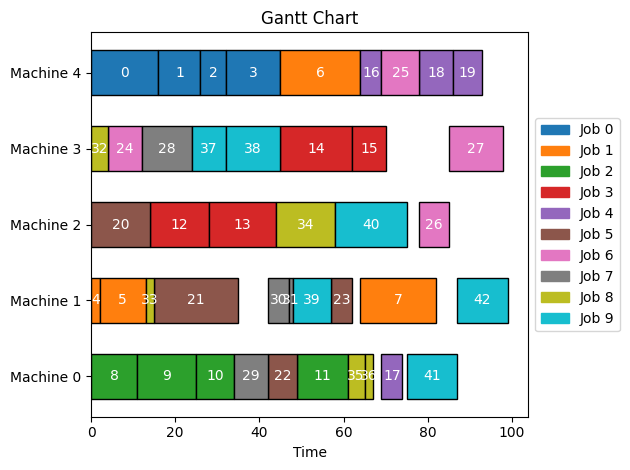

In [8]:
fig = None
env.render(td1.cpu(), 0)
plt.show()

actions = out["actions"]

for step in range(actions.shape[1]):
    td1["action"] = actions[:, step]
    td1 = env.step(td1)["next"]

    clear_output(wait=True)
    if fig is not None:
        plt.close(fig)
    fig = plt.figure()
    env.render(td1.cpu(), 0)
    plt.show()
    time.sleep(1)

In [9]:
last_op_finish_times = td1["finish_times"].gather(1, td1["end_op_per_job"])
print("Makespan:", last_op_finish_times.max().item())

Makespan: 99.0


In [10]:
actions_untrained = out['actions'].cpu().detach()
rewards_untrained = out['reward'].cpu().detach()
print(f"Cost: {-rewards_untrained[0]}")

Cost: 99.0


## Обучение

In [11]:
policy.train()

L2DPolicy(
  (encoder): HetGNNEncoder(
    (init_embedding): FJSPInitEmbedding(
      (init_ops_embed): Linear(in_features=5, out_features=128, bias=False)
      (pos_encoder): PositionalEncoding(
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (init_ma_embed): Linear(in_features=1, out_features=128, bias=False)
      (edge_embed): Linear(in_features=1, out_features=128, bias=False)
    )
    (layers): ModuleList(
      (0-3): 4 x HetGNNBlock(
        (hgnn1): HetGNNLayer(
          (activation): ReLU()
        )
        (hgnn2): HetGNNLayer(
          (activation): ReLU()
        )
        (ffn1): TransformerFFN(
          (ops): ModuleDict(
            (norm1): Normalization(
              (normalizer): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            )
            (ffn): Sequential(
              (0): Linear(in_features=128, out_features=256, bias=True)
              (1): ReLU()
              (2): Linear(in_features=256, out

In [12]:
checkpoint_callback = ModelCheckpoint(
    dirpath="checkpoints",
    filename="epoch_{epoch:03d}",
    save_top_k=1,
    save_last=True,
    monitor="val/reward",
    mode="max",  # maximize reward = minimize makespan
)

rich_model_summary = RichModelSummary(max_depth=3)

callbacks = [checkpoint_callback, rich_model_summary]

In [14]:
trainer = RL4COTrainer(
    max_epochs=1000,
    accelerator=accelerator,
    devices=1,
    logger=None,
    callbacks=callbacks,
)

Using 16bit Automatic Mixed Precision (AMP)
Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.rich_model_summary.RichModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores


In [15]:
trainer.fit(model)

/home/egor/cousework/10.12.25/rl4co_try/.venv/lib/python3.12/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:881: Checkpoint directory /home/egor/cousework/10.12.25/rl4co_try/checkpoints exists and is not empty.
val_file not set. Generating dataset instead
test_file not set. Generating dataset instead
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/egor/cousework/10.12.25/rl4co_try/.venv/lib/python3.12/site-packages/lightning/pytorch/utilities/model_summary/model_summary.py:242: Precision 16-mixed is not supported by the model summary.  Estimated model size in MB will not be accurate. Using 32 bits instead.


┏━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃    ┃ Name                          ┃ Type                ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0  │ env                           │ FJSPEnv             │      0 │ train │     0 │
│ 1  │ policy                        │ L2DPolicy           │  585 K │ train │     0 │
│ 2  │ policy.encoder                │ HetGNNEncoder       │  535 K │ train │     0 │
│ 3  │ policy.encoder.init_embedding │ FJSPInitEmbedding   │    896 │ train │     0 │
│ 4  │ policy.encoder.layers         │ ModuleList          │  534 K │ train │     0 │
│ 5  │ policy.decoder                │ L2DDecoder          │ 49.8 K │ train │     0 │
│ 6  │ policy.decoder.actor          │ FJSPActor           │ 49.8 K │ train │     0 │
│ 7  │ baseline                      │ WarmupBaseline      │  585 K │ train │     0 │
│ 8  │ baseline.baseline             │ RolloutBaseline     │  585 K │ train │     0 │
│ 9  │ baseline.baseline.policy      │ L2DPolicy           │  585 K │ eval  │     0 │
│ 10 │ baseline.warmup_baseline      │ ExponentialBaseline │      0 │ train │     0 │
└────┴───────────────────────────────┴─────────────────────┴────────┴───────┴───────┘

Trainable params: 1.2 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 1.2 M                                                                                                
Total estimated model params size (MB): 4                                                                          
Modules in train mode: 124                                                                                         
Modules in eval mode: 120                                                                                          
Total FLOPs: 0

Output()

/home/egor/cousework/10.12.25/rl4co_try/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/dat
a_connector.py:434: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing 
the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.

/home/egor/cousework/10.12.25/rl4co_try/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/dat
a_connector.py:434: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider 
increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.

/home/egor/cousework/10.12.25/rl4co_try/.venv/lib/python3.12/site-packages/lightning/pytorch/loops/fit_loop.py:317:
The number of training batches (8) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower 
value for log_every_n_steps if you want to see logs for the training epoch.

/home/egor/cousework/10.12.25/rl4co_try/.venv/lib/python3.12/site-packages/lightning/pytorch/loops/fit_loop.py:534:
Found 120 module(s) in eval mode at the start of training. This may lead to unexpected behavior during training. If
this is intentional, you can ignore this warning.

`Trainer.fit` stopped: `max_epochs=1000` reached.


## Тестирование обученной модели

In [16]:
policy.eval()
policy.to(device) # добавил и ошибка исчезла ???? почему ?????
td2 = td.clone()

with torch.no_grad():
    out = policy(td2.clone(), phase="test", decode_type="greedy", return_actions=True)

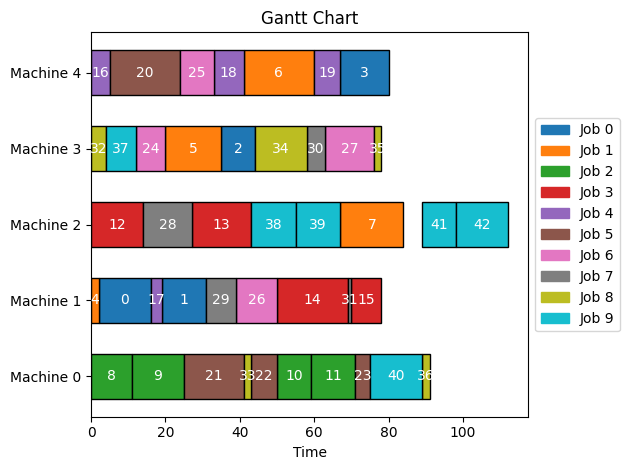

In [17]:
fig = None
env.render(td2.cpu(), 0)
plt.show()

actions = out["actions"]

for step in range(actions.shape[1]):
    td2["action"] = actions[:, step]
    td2 = env.step(td2)["next"]

    clear_output(wait=True)
    if fig is not None:
        plt.close(fig)
    fig = plt.figure()
    env.render(td2.cpu(), 0)
    plt.show()
    time.sleep(1)

In [18]:
last_op_finish_times = td2["finish_times"].gather(1, td2["end_op_per_job"])
print("Makespan:", last_op_finish_times.max().item())

Makespan: 112.0


In [19]:
actions_untrained = out['actions'].cpu().detach()
rewards_untrained = out['reward'].cpu().detach()
print(f"Cost: {-rewards_untrained[0]}")

Cost: 112.0


In [20]:
trainer.test(model)

val_file not set. Generating dataset instead
test_file not set. Generating dataset instead
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

/home/egor/cousework/10.12.25/rl4co_try/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        test/reward        │    -101.34559631347656    │
└───────────────────────────┴───────────────────────────┘

[{'test/reward': -101.34559631347656}]